<a href="https://colab.research.google.com/github/AndryRafam/Hate-Speech-Detection/blob/main/Bert_Multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# BERT MULTI-LANGUAGE

In [2]:
pip install --upgrade tensorflow-text

     |████████████████████████████████| 4.9 MB 5.4 MB/s 


In [17]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [18]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [19]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [20]:
bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3")
bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4",trainable=True)

In [21]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(bert_preprocess_model, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(bert_model, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [22]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [30]:
pip install --upgrade tensorflow-model-optimization

In [31]:
pip install --upgrade tf-models-official

     |████████████████████████████████| 1.8 MB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 38.4 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 352 kB 43.4 MB/s 
     |████████████████████████████████| 1.2 MB 39.2 MB/s 
     |████████████████████████████████| 596 kB 42.4 MB/s 
     |████████████████████████████████| 99 kB 8.3 MB/s 
     |████████████████████████████████| 90 kB 8.5 MB/s 
     |████████████████████████████████| 47.7 MB 52.8 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=3c53ebe67b8def82eed4fabad2ad6c032885a77d60f892ed455849908fa4a607
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=8785a7c80cc5cf8c0d195fe7f0fac10897cbaaba45958969342bb3871843de5a
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b

In [32]:
from official.nlp import optimization  # to create AdamW optimizer

In [33]:
classifier_model = build_classifier_model()

In [34]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [36]:
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [37]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [38]:
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Epoch 1/2
625/625 [==============================] - 1196s 2s/step - loss: 0.4586 - binary_accuracy: 0.7656 - val_loss: 0.3442 - val_binary_accuracy: 0.8450
Epoch 2/2
625/625 [==============================] - 1148s 2s/step - loss: 0.2680 - binary_accuracy: 0.8844 - val_loss: 0.3568 - val_binary_accuracy: 0.8560


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


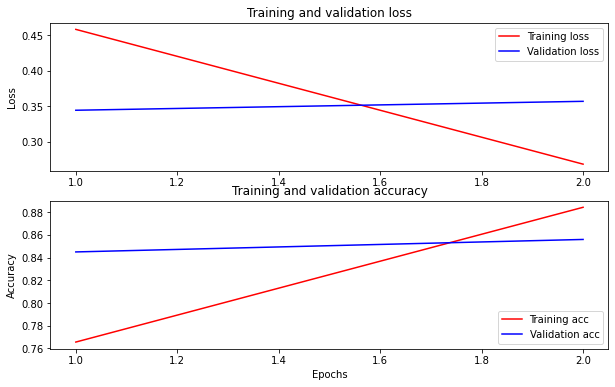

In [39]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [40]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./imdb_bert/assets


INFO:tensorflow:Assets written to: ./imdb_bert/assets


In [41]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [50]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',
    'The movie was great!',
    'The movie was meh.',
    'Dieser Film war schrecklich',
    'Ce film était horrible ...', 
    'Ce film est vraiment bien', 
    'Sehr gut !!!'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.996253
input: The movie was great!           : score: 0.996634
input: The movie was meh.             : score: 0.357938
input: Dieser Film war schrecklich    : score: 0.011753
input: Ce film était horrible ...     : score: 0.006135
input: Ce film est vraiment bien      : score: 0.991482
input: Sehr gut !!!                   : score: 0.991161

Results from the model in memory:
input: this is such an amazing movie! : score: 0.996253
input: The movie was great!           : score: 0.996634
input: The movie was meh.             : score: 0.357937
input: Dieser Film war schrecklich    : score: 0.011753
input: Ce film était horrible ...     : score: 0.006135
input: Ce film est vraiment bien      : score: 0.991482
input: Sehr gut !!!                   : score: 0.991161

